## Example from https://scikit-learn.org/stable/auto_examples/neighbors/plot_species_kde.html

 - computing KDE in spherical coordinates
 - plot coastlines from coverage
 - computing KDE in spherical coordinates
 - plot coastlines from coverage


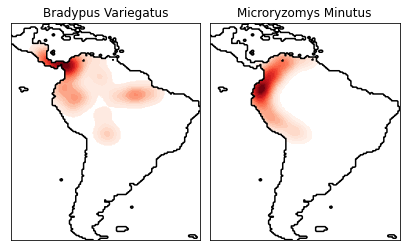

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_species_distributions
from sklearn.neighbors import KernelDensity

# if basemap is available, we'll use it.
# otherwise, we'll improvise later...
try:
    from mpl_toolkits.basemap import Basemap
    basemap = True
except ImportError:
    basemap = False


def construct_grids(batch):
    """Construct the map grid from the batch object

    Parameters
    ----------
    batch : Batch object
        The object returned by :func:`fetch_species_distributions`

    Returns
    -------
    (xgrid, ygrid) : 1-D arrays
        The grid corresponding to the values in batch.coverages
    """
    # x,y coordinates for corner cells
    xmin = batch.x_left_lower_corner + batch.grid_size
    xmax = xmin + (batch.Nx * batch.grid_size)
    ymin = batch.y_left_lower_corner + batch.grid_size
    ymax = ymin + (batch.Ny * batch.grid_size)

    # x coordinates of the grid cells
    xgrid = np.arange(xmin, xmax, batch.grid_size)
    # y coordinates of the grid cells
    ygrid = np.arange(ymin, ymax, batch.grid_size)

    return (xgrid, ygrid)


# Get matrices/arrays of species IDs and locations
data = fetch_species_distributions()
species_names = ['Bradypus Variegatus', 'Microryzomys Minutus']

Xtrain = np.vstack([data['train']['dd lat'],
                    data['train']['dd long']]).T
ytrain = np.array([d.decode('ascii').startswith('micro')
                  for d in data['train']['species']], dtype='int')
Xtrain *= np.pi / 180.  # Convert lat/long to radians

# Set up the data grid for the contour plot
xgrid, ygrid = construct_grids(data)
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
land_reference = data.coverages[6][::5, ::5]
land_mask = (land_reference > -9999).ravel()

xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = xy[land_mask]
xy *= np.pi / 180.

# Plot map of South America with distributions of each species
fig = plt.figure()
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)

for i in range(2):
    plt.subplot(1, 2, i + 1)

    # construct a kernel density estimate of the distribution
    print(" - computing KDE in spherical coordinates")
    kde = KernelDensity(bandwidth=0.04, metric='haversine',
                        kernel='gaussian', algorithm='ball_tree')
    kde.fit(Xtrain[ytrain == i])

    # evaluate only on the land: -9999 indicates ocean
    Z = np.full(land_mask.shape[0], -9999, dtype='int')
    Z[land_mask] = np.exp(kde.score_samples(xy))
    Z = Z.reshape(X.shape)

    # plot contours of the density
    levels = np.linspace(0, Z.max(), 25)
    plt.contourf(X, Y, Z, levels=levels, cmap=plt.cm.Reds)

    if basemap:
        print(" - plot coastlines using basemap")
        m = Basemap(projection='cyl', llcrnrlat=Y.min(),
                    urcrnrlat=Y.max(), llcrnrlon=X.min(),
                    urcrnrlon=X.max(), resolution='c')
        m.drawcoastlines()
        m.drawcountries()
    else:
        print(" - plot coastlines from coverage")
        plt.contour(X, Y, land_reference,
                    levels=[-9998], colors="k",
                    linestyles="solid")
        plt.xticks([])
        plt.yticks([])

    plt.title(species_names[i])

plt.show()

# Another example that uses shapefiles
https://towardsdatascience.com/visualizing-geospatial-data-in-python-e070374fe621

In [2]:
import geoplot as gplt
import geopandas as gpd
import geoplot.crs as gcrs
import imageio
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import mapclassify as mc
import numpy as np

%matplotlib inline

<AxesSubplot:>

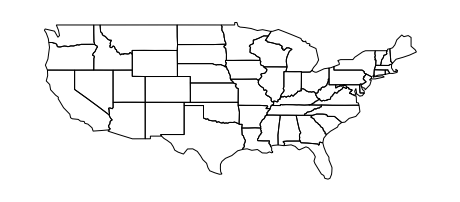

In [63]:
path = gplt.datasets.get_path("contiguous_usa")
contiguous_usa = gpd.read_file(path)
gplt.polyplot(contiguous_usa)

## Try with our data

In [24]:
#Prepare my shapefile data

# read in the shapefile 
nz_SA2 = gpd.read_file('statsnzstatistical-area-2-2018-generalised-SHP/statistical-area-2-2018-generalised.shp')

#Read in the complete set
groupA=pd.read_csv("../CompleteSet_GroupA.csv")
groupA=groupA.drop("Unnamed: 0",axis=1)

#Strip all leading whitespace in Area column
groupA['Area'] = groupA['Area'].apply(lambda x: x.strip())

#Add column to GIS data for the geog values in 2020
waikato=subsetData=groupA[(groupA.Year==2020)&(groupA.ParentArea == 'WaikatoRegion')]
nz_SA2["TotInd_GeogUnits"] = np.nan
nz_SA2["ParentArea"] = " "
for i in range(len(waikato)):
    nz_SA2.loc[nz_SA2['SA22018__1']==waikato.iloc[i,0],'TotInd_GeogUnits']=waikato.iloc[i,1]
    nz_SA2.loc[nz_SA2['SA22018__1']==waikato.iloc[i,0],'ParentArea']="WaikatoRegion"

#test=nz_SA2.merge(waikato,left_on="SA22018__1", right_on="Area") # That works, but not completely what I want
waikatoMap=nz_SA2[nz_SA2.ParentArea=="WaikatoRegion"]
#Remove Oceanic regions
waikatoMap=waikatoMap.drop(waikatoMap[waikatoMap.SA22018__1=="Oceanic Waikato Region West"].index)
waikatoMap=waikatoMap.drop(waikatoMap[waikatoMap.SA22018__1=="Oceanic Waikato Region East"].index)

waikatoMap.head()

,SA22018_V1,SA22018__1,LAND_AREA_,AREA_SQ_KM,Shape_Leng,geometry,TotInd_GeogUnits,ParentArea
97,180400,Deanwell,0.670205,0.670205,4525.397211,"POLYGON ((1800206.915 5811881.834, 1800217.350...",81.0,WaikatoRegion
98,187700,Marotiri,744.191006,744.191006,146011.095712,"POLYGON ((1834774.551 5757130.793, 1834795.111...",330.0,WaikatoRegion
99,187800,Ohakuri,543.104997,543.104997,123353.328064,"POLYGON ((1865805.927 5747045.855, 1865875.456...",354.0,WaikatoRegion
100,187900,Lake Taupo Bays,1154.667424,1170.016349,335094.197805,"POLYGON ((1840518.546 5716897.317, 1841429.356...",249.0,WaikatoRegion
101,188000,Mapara,140.665785,140.665785,79055.704871,"POLYGON ((1862727.755 5720960.313, 1863201.777...",333.0,WaikatoRegion


In [132]:
# get some coordinates
from shapely import wkt

#waikatoMap['geometry'] = waikatoMap['geometry'].apply(wkt.loads)
#my_geo_df = gpd.GeoDataFrame(my_df, geometry='geometry')
#print(waikatoMap[waikatoMap.SA22018__1=="Cambridge Central"].geometry[1][1])
#type(waikatoMap)
nz_SA2.geometry[1][3] 
print(nz_SA2.geometry[1][3]) #this prints out the entire object

#type(print(nz_SA2.geometry[1][3]))
#f = open("demotext3.txt", "w")
#f.write(print(nz_SA2.geometry[1][3]))
#f.close()
type(nz_SA2.geometry)

POLYGON ((1631982.9225 6152039.5939, 1631970.2129 6152037.0599, 1631944.8137 6152053.5937, 1631914.3453 6152082.8371, 1631880.0625 6152110.8108, 1631777.2646 6152248.1042, 1631755.7023 6152291.3202, 1631730.3142 6152318.0187, 1631680.7896 6152354.8973, 1631643.9789 6152396.8515, 1631622.4149 6152436.2543, 1631608.4683 6152469.3005, 1631579.2812 6152509.9807, 1631570.4043 6152530.3159, 1631578.0442 6152546.8332, 1631579.3301 6152563.3501, 1631576.7939 6152567.8351, 1631576.8323 6152607.8271, 1631583.2093 6152633.2389, 1631597.2067 6152654.8335, 1631628.9707 6152649.7342, 1631648.0113 6152628.1219, 1631660.6901 6152598.8871, 1631686.062 6152553.1281, 1631717.7691 6152488.3029, 1631752.0297 6152437.4561, 1631783.7797 6152418.378, 1631810.4567 6152410.7395, 1631838.4031 6152400.5587, 1631873.9657 6152381.4781, 1631919.6552 6152323.0005, 1631933.6157 6152302.662, 1631929.7895 6152288.6861, 1631909.4474 6152278.5303, 1631895.4671 6152274.7271, 1631890.3733 6152263.2913, 1631901.7911 6152244.

geopandas.geoseries.GeoSeries

In [119]:
# Start the plotting
#waikatoMap[waikatoMap.SA22018__1=="Cambridge Central"].plot()
#nz_SA2.plot()
nz_SA2.shape

(2237, 8)

geopandas.geoseries.GeoSeries

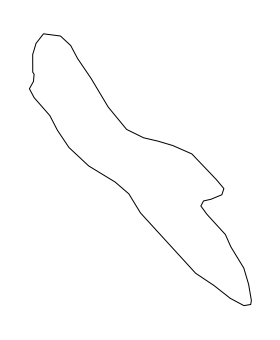

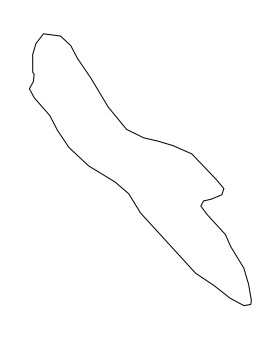

In [134]:
from shapely import wkt
df = pd.DataFrame(
    {'Area': ['Some place'],
     'Coordinates': ['POLYGON ((173.34935104 -34.77513480,173.34921224 -34.77515805,173.34893404 -34.77500975,173.34859996 -34.77474700,173.34822425 -34.77449582,173.34709565 -34.77326097,173.34685838 -34.77287194,173.34657993 -34.77263197,173.34603733 -34.77230096,173.34563349 -34.77192377,173.34539636 -34.77156912,173.34524271 -34.77127156,173.34492223 -34.77090563,173.34482446 -34.77072253,173.34490733 -34.77057334,173.34492076 -34.77042436,173.34489288 -34.77038400,173.34489180 -34.77002336,173.34496053 -34.76979401,173.34511268 -34.76959885,173.34545998 -34.76964385,173.34566886 -34.76983815,173.34580851 -34.77010138,173.34608749 -34.77051323,173.34643642 -34.77109681,173.34681274 -34.77155426,173.34716042 -34.77172531,173.34745224 -34.77179336,173.34775802 -34.77188430,173.34814737 -34.77205525,173.34864889 -34.77258114,173.34880222 -34.77276411,173.34876094 -34.77289026,173.34853902 -34.77298248,173.34838638 -34.77301721,173.34833115 -34.77312049,173.34845665 -34.77329207,173.34883285 -34.77370369,173.34894471 -34.77395550,173.34920990 -34.77439030,173.34930813 -34.77472237,173.34936469 -34.77505455,173.34935104 -34.77513480))']})
df['Coordinates'] = gpd.GeoSeries.from_wkt(df['Coordinates'])
gdf = gpd.GeoDataFrame(df, geometry='Coordinates')
gdf.geometry
gplt.polyplot(gdf)


df2 = pd.DataFrame(
    {'Area': ['Some place'],
     'Coordinates': ['POLYGON ((173.3495294566975 -34.773312632285176,173.34939065244086 -34.773335881608105,173.34911245278386 -34.773187580695755,173.3487783648716 -34.7729248330555,173.34840264639476 -34.77267364710855,173.3472740567341 -34.77143880142395,173.3470367805021 -34.77104976805901,173.34675832951663 -34.770809797226754,173.34621573643741 -34.77047878573454,173.34581188485524 -34.77010160382972,173.3455747517379 -34.769746951680084,173.3454210975835 -34.76944938792272,173.345100616694 -34.76908344657922,173.34500284669494 -34.76890034817607,173.34508571568358 -34.76875116752312,173.34509914893303 -34.76860218363904,173.3450712676209 -34.768561818152705,173.34507018191468 -34.768201184242834,173.34513891442904 -34.767971830905786,173.345291070093 -34.76777667065775,173.34563836995414 -34.76782166664062,173.34584724684035 -34.768015964654516,173.34598689996494 -34.76827920117309,173.3462658831592 -34.76869105027472,173.34661481615873 -34.76927463155706,173.34699113663328 -34.769732083950856,173.34733882071424 -34.76990313272752,173.34763063579135 -34.76997117726101,173.34793641523794 -34.77006211326108,173.34832577137743 -34.770233067157065,173.34882728151044 -34.77075896076249,173.34898062095087 -34.77094193280728,173.34893932944874 -34.771068082853816,173.34871741420767 -34.77116030266071,173.34856478265525 -34.77119503413356,173.34850954809372 -34.771298318933304,173.3486350491748 -34.77146990053772,173.3490112525162 -34.77188151873107,173.34912311598637 -34.77213333349965,173.3493883017366 -34.77256813770799,173.34948652802618 -34.77290019484547,173.34954309595005 -34.7732323805119,173.3495294566975 -34.773312632285176))']})
df2['Coordinates'] = gpd.GeoSeries.from_wkt(df2['Coordinates'])
gdf2 = gpd.GeoDataFrame(df2, geometry='Coordinates')
gdf2.geometry
gplt.polyplot(gdf2)


In [151]:
# I dowloaded this function from this blogpost: https://gis.stackexchange.com/questions/225065/converting-nztm-new-zealand-transverse-mercator-to-lat-long
# It creates coordinates that do not exactly match the coordinates obtained from the online converter at: https://www.geodesy.linz.govt.nz/concord/
# But, when plotted the shape of the polygon is closely mimicked, I'm just not sure whether that's good enough when everything is mapped like that
# But I AM using this now because there are more than 2 million coordinates to convert and I can't do that manually interfacing with the online tool
# I have checked that the equations in this function were not incorrectly copied from teh SQL code in the same post. (It wasn't)
# But I have not checked it against the underlying formulae that you can find here: https://www.linz.govt.nz/data/geodetic-services/coordinate-conversion/projection-conversions/transverse-mercator-transformation-formulae

def nztm_to_lat_long(input_filename, output_filename):
    import math
    infile = open(input_filename)
    lines = infile.readlines()
    infile.close()
        
    outfile = open(output_filename, 'w')
    outfile.write("site_id, easting, northing, longitude, latitude\n")
        
    for line in lines[1:5]: #skip header row
        site_id, nztm_e, nztm_n = line.split(',')
        
            
        #Common variables for NZTM2000
        a = 6378137;
        f = 1 / 298.257222101;
        phizero = 0;
        lambdazero = 173;
        Nzero = 10000000;
        Ezero = 1600000;
        kzero = 0.9996;   
        
            
        #input Northing(Y); Easting(X) variables
        E  = float(nztm_e);#neither int(float(nztm_e)) or this produces the right decimals
        N  = float(nztm_n);
            
        #Calculation: From NZTM to lat/Long
        b = a * (1 - f);
        esq = 2 * f - f ** 2;
        Z0 = 1 - esq / 4 - 3 * (esq ** 2) / 64 - 5 * (esq ** 3) / 256;
        A2 = 0.375 * (esq + esq ** 2 / 4 + 15 * (esq ** 3) / 128);
        A4 = 15 * ((esq ** 2) + 3 * (esq ** 3) / 4) / 256;
        A6 = 35 * (esq ** 3) / 3072;
            
        Nprime = N - Nzero;
        mprime = Nprime / kzero;
        smn = (a - b) / (a + b);
        G = a * (1 - smn) * (1 - (smn ** 2)) * (1 + 9 * (smn ** 2) / 4 + 225 * (smn ** 4) / 64) * math.pi/ 180.0;
        sigma = mprime * math.pi / (180 * G);
        phiprime = sigma + (3 * smn / 2 - 27 * (smn ** 3) / 32) * math.sin(2 * sigma) + (21 * (smn ** 2) / 16 - 55 * (smn ** 4) / 32) * math.sin(4 * sigma) + (151 * (smn ** 3) / 96) * math.sin(6 * sigma) + (1097 * (smn ** 4) / 512) *math.sin(8 * sigma);
        rhoprime = a * (1 - esq) / ((1 - esq * ((math.sin(phiprime)) ** 2)) ** 1.5);
        upsilonprime = a / math.sqrt(1 - esq * ((math.sin(phiprime)) ** 2));
            
        psiprime = upsilonprime / rhoprime;
        tprime = math.tan(phiprime);
        Eprime = E - Ezero;
        chi = Eprime / (kzero * upsilonprime);
        term_1 = tprime * Eprime * chi / (kzero * rhoprime * 2);
        term_2 = term_1 * (chi ** 2) / 12 * (-4 * (psiprime ** 2) + 9 * psiprime * (1 - (tprime ** 2)) + 12 * (tprime ** 2));
        term_3 = tprime * Eprime * (chi ** 5) / (kzero * rhoprime * 720) * (8 * (psiprime ** 4) * (11 - 24 * (tprime ** 2)) - 12 * (psiprime ** 3) * (21 - 71 * (tprime ** 2)) + 15 * (psiprime ** 2) * (15 - 98 * (tprime ** 2) + 15 * (tprime ** 4)) + 180 * psiprime * (5 * (tprime ** 2) - 3 * (tprime ** 4)) + 360 * (tprime ** 4));
        term_4 = tprime * Eprime * (chi ** 7) / (kzero * rhoprime * 40320) * (1385 + 3633 * (tprime ** 2) + 4095 * (tprime ** 4) + 1575 * (tprime ** 6));
        term1 = chi * (1 / math.cos(phiprime));
        term2 = (chi ** 3) * (1 / math.cos(phiprime)) / 6 * (psiprime + 2 * (tprime ** 2));
        term3 = (chi ** 5) * (1 / math.cos(phiprime)) / 120 * (-4 * (psiprime ** 3) * (1 - 6 * (tprime ** 2)) + (psiprime ** 2) * (9 - 68 * (tprime ** 2)) + 72 * psiprime * (tprime ** 2) + 24 * (tprime ** 4));
        term4 = (chi ** 7) * (1 / math.cos(phiprime)) / 5040 * (61 + 662 * (tprime ** 2) + 1320 * (tprime ** 4) + 720 * (tprime ** 6));        
        
        latitude = (phiprime - term_1 + term_2 - term_3 + term_4) * 180 / math.pi;
        longitude = lambdazero + 180 / math.pi * (term1 - term2 + term3 - term4);  
        outfile.write("{},{},{},{},{}\n".format(site_id, E, N, longitude, latitude))
    outfile.close()

nztm_to_lat_long('inputFile.csv', 'outputFile.csv')

6185741.2646

6185741.2646
6185698.7023

6185698.7023
6185675.7111

6185675.7111
6185666.6415

6185666.6415


<AxesSubplot:>

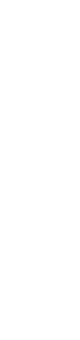

In [62]:
# Plotting with geoplot - this does not work because the coordinates are in NZTM and not long/lat
nz_SA2=nz_SA2.drop(nz_SA2[nz_SA2['geometry']==None].index)
#waikatoMap=waikatoMap.drop(waikatoMap[waikatoMap.SA22018__1=="Oceanic Waikato Region West"].index)
gplt.polyplot(nz_SA2)



## Let's recreate with our data

* First test is in Waikato region alone

In [152]:
# packages for KDE
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

# import necessary additional packages for mapping
%matplotlib inline
import geopandas as gpd
import seaborn as sns
import pandas as pd
import pysal
import mapclassify

# read in the shapefile 
nz_SA2 = gpd.read_file('statsnzstatistical-area-2-2018-generalised-SHP/statistical-area-2-2018-generalised.shp')

# read in the data
# First read file A
from pandas import DataFrame, read_csv
import numpy as np

#Read in the complete set
groupA=pd.read_csv("../CompleteSet_GroupA.csv")
groupA=groupA.drop("Unnamed: 0",axis=1)

#Strip all leading whitespace in Area column
groupA['Area'] = groupA['Area'].apply(lambda x: x.strip())

#Add column to GIS data for the geog values in 2020
waikato=subsetData=groupA[(groupA.Year==2020)&(groupA.ParentArea == 'WaikatoRegion')]
nz_SA2["TotInd_GeogUnits"] = np.nan
nz_SA2["ParentArea"] = " "
for i in range(len(waikato)):
    nz_SA2.loc[nz_SA2['SA22018__1']==waikato.iloc[i,0],'TotInd_GeogUnits']=waikato.iloc[i,1]
    nz_SA2.loc[nz_SA2['SA22018__1']==waikato.iloc[i,0],'ParentArea']="WaikatoRegion"

waikatoMap=nz_SA2[nz_SA2.ParentArea=="WaikatoRegion"]
#Remove Oceanic regions
waikatoMap=waikatoMap.drop(waikatoMap[waikatoMap.SA22018__1=="Oceanic Waikato Region West"].index)
waikatoMap=waikatoMap.drop(waikatoMap[waikatoMap.SA22018__1=="Oceanic Waikato Region East"].index)


In [154]:
nz_SA2.dtypes

SA22018_V1            object
SA22018__1            object
LAND_AREA_           float64
AREA_SQ_KM           float64
Shape_Leng           float64
geometry            geometry
TotInd_GeogUnits     float64
ParentArea            object
dtype: object